# A Gentle Introduction to Using HARK

This notebook provides a simple, hands on tutorial for first time HARK users-- and potentially first time Python users.  It does not go "into the weeds" - we have hidden some code cells that do boring things that you don't need to digest on your first experience with HARK.  Our aim is to convey a feel for how the toolkit works and how to set up and use different $\texttt{AgentType}$s.

For readers for whom this is your very first experience with Python, we have put important Python concepts in $\textbf{boldface}$. Only cursory definitions (if any) are provided here.  If you want to learn more, there are many online Python tutorials.

In [2]:
# This cell has just a bit of initial setup. You can click the arrow to expand it.
%matplotlib inline
import matplotlib.pyplot as plt

# The first step is to be able to bring things in from different directories
import sys 
import os

sys.path.insert(0, os.path.abspath('../lib'))

from util import log_progress

import numpy as np
import HARK # Prevents import error from Demos repo
from time import clock
from copy import deepcopy
mystr = lambda number : "{:.4f}".format(number)
from HARK.utilities import plotFuncs

## Your First HARK Model: Perfect Foresight

For the sake of simplicity, let's start with the almost the simplest possible consumption model: a problem in which the consumer has perfect foresight about everything except the date of death, which is stochastic (this is captured by a "survival probability" $\mathsf{D} < 1$).  Income $Y_t$ grows from period to period by a factor $\Gamma_t$.  Each period $t$, he must choose how much of his market resources $M_t$ to consume $C_t$ and how much to retain in a riskless asset $A_t$ with return factor $R$. The agent receives a flow of utility $U(C_t)$ from consumption (with CRRA preferences) and geometrically discounts future utility flows by factor $\beta$. Between periods, the agent dies with probability $\mathsf{D}_t$, ending his problem.

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
V_t(M_t) &=& \max_{C_t} U(C_t) + \beta (1-\mathsf{D}_{t+1}) V_{t+1}(M_{t+1}), \\
A_t &=& M_t - C_t, \\
M_{t+1} &=& R A_t + Y_{t+1}, \\
Y_{t+1} &=& \Gamma_{t+1} Y_t, \\
U(C) &=& \frac{C^{1-\rho}}{1-\rho}.
\end{eqnarray*}

A particular perfect foresight agent's problem can be characterized by values of risk aversion $\rho$, discount factor $\beta$, and return factor $R$, along with sequences of income growth factors $\{ \Gamma_t \}$ and survival probabilities $\{1 - \mathsf{D}_t\}$.  To keep things simple, let's forget about "sequences" of income growth and mortality, and just think about an $\textit{infinite horizon}$ consumer with constant income growth and survival probability.

## Representing Agents in HARK

HARK represents agents with this type of problem as $\textbf{instances}$ of the $\textbf{class}$ $\texttt{PerfForesightConsumerType}$, a $\textbf{subclass}$ of $\texttt{AgentType}$.  To make agents of this class, we must import the class itself into our workspace.

In [4]:
from Demos.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType

To create an instance of $\texttt{PerfForesightConsumerType}$, we simply call the class as if it were a function, passing as arguments the specific parameter values we want it to have.  In the hidden cell below, I define a $\textbf{dictionary}$ named $\texttt{PF_dictionary}$ with parameter values as given in this table:

| Param | Description | Code | Value |
| :---: | --- | --- | --- | :---: |
| $\rho$ | Relative risk aversion | $\texttt{CRRA}$ | 2.5 |
| $\beta$ | Discount factor | $\texttt{DiscFac}$ | 0.96 |
| $R$ | Risk free interest factor | $\texttt{Rfree}$ | 1.03 |
| $1 - \mathsf{D}$ | Survival probability | $\texttt{LivPrb}$ | 0.98 |
| $\Gamma$ | Income growth factor | $\texttt{PermGroFac}$ | 2.5 |


For now, don't worry about the specifics of dictionaries.  All you need to know is that a dictionary lets us pass many arguments wrapped up in one simple data structure.

In [5]:
# This cell defines a parameter dictionary. You can expand it if you want to see what that looks like.
PF_dictionary = {
    'CRRA' : 2.5,
    'DiscFac' : 0.96,
    'Rfree' : 1.03,
    'LivPrb' : [0.98],
    'PermGroFac' : [1.01],
    'T_cycle' : 1,
    'cycles' : 0,
    'AgentCount' : 10000
}

# To those curious enough to open this hidden cell, you might notice that we defined
# a few extra parameters in that dictionary: T_cycle, cycles, and AgentCount. Don't
# worry about these for now.

Let's make an instance of the $\texttt{PerfForesightConsumerType}$ class.  The object we create is merely a "configured" instance of the class: It has the parameter values needed to turn the abstract mathematical description of the problem into an object that represents the specific consumption function of a consumer with the configured parameters. 

We have stored parameter values are stored in a "dictionary" ($\texttt{PF_dictionary}$).  The instance is created by passing the dictionary $\texttt{PF_dictionary}$ to the class $\texttt{PFexample}$ as if the class were a function.  (The double asterisks $**$ in this line simply tell Python to read the entries in the dictionary as arguments.)

In [6]:
PFexample = PerfForesightConsumerType(**PF_dictionary)

We now have a representation of an infinite horizon perfect foresight consumer with the parameter values given in the table above.  As is, the object named $\texttt{PFexample}$ knows what problem the agent faces, but it hasn't actually solved that problem.


## Solving an Agent's Problem

Let's solve this agent's problem-- find the consumption function that maximizes his discounted stream of utility. To do this, we call our agent's $\texttt{solve}$ method. A $\textbf{method}$ is essentially a function that an object runs on itself.

In the cell below, I call the $\texttt{solve}$ method for $\texttt{PFexample}$, then plot the agent's consumption function on [0,10]. The horizontal axis is market resources divided by current income $m_t \equiv M_t/Y_t$, and the vertical axis is consumption divided by current income $c_t \equiv C_t/Y_t$.

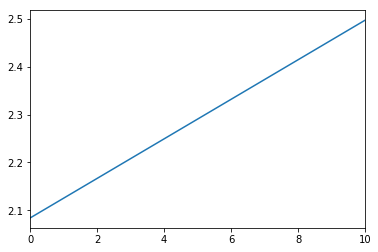

In [7]:
PFexample.solve()
plotFuncs(PFexample.solution[0].cFunc,0.,10.)

Running the $\texttt{solve}$ method creates the $\textbf{attribute}$ of $\texttt{PFexample}$ named $\texttt{solution}$.  In fact, every subclass of $\texttt{AgentType}$ uses the same $\texttt{solve}$ method; the details of the computation obviously varies from subclass to subclass, but the interface is always the same.

The $\texttt{solution}$ attribute is always a $\textit{list}$ of solutions to a single period of the problem. In this case, there is just one element in that list-- the solution to all periods of the infinite horizon problem.

Unsurprisingly, our perfect foresight consumer with CRRA utility has a linear consumption function. Perhaps slightly more surprisingly, HARK thinks he should optimally consume over $\textit{twice}$ his current income when he has zero market resources. What gives?

In this very simple model, there is no artificially imposed borrowing constraint.  The agent is free to hold negative assets and can borrow against the entire PDV of his future earnings-- his human wealth.  How much is that?  What's the minimum value of $m_t$ where the consumption function is defined?  Let's check:

In [8]:
print("This agent's human wealth is " + str(PFexample.solution[0].hNrm) + ' times his current income level.')
print("This agent's consumption function is defined down to m_t = " + str(PFexample.solution[0].mNrmMin))

This agent's human wealth is 50.4999499255 times his current income level.
This agent's consumption function is defined down to m_t = -50.4999499255


Yikes! Let's take a look at the bottom of the consumption function.  In the cell below, set the bounds of the $\texttt{plotFuncs}$ function to display down to the lowest defined value of the consumption function.

In [9]:
# Fill in values for bottom and top to plot the range you're interested in.
plotFuncs(PFexample.solution[0].cFunc,bottom,top)

NameError: name 'bottom' is not defined

## Changing Agent Parameters

Suppose you wanted to change one (or more) of the parameters of the agent's problem and see what that does.  This is very easy to do in HARK.  So that we can compare consumption functions before and after we change parameters, let's make a new instance of $\texttt{PerfForesightConsumerType}$ by copying $\texttt{PFexample}$.

In [10]:
NewExample = deepcopy(PFexample)

In Python, you can set an $\textbf{attribute}$ of an object just like any other variable.  For example, we could make the new agent less patient:

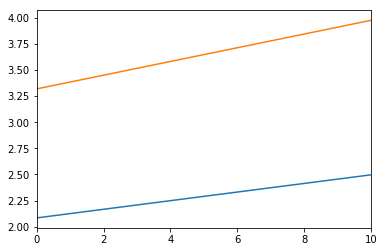

In [11]:
NewExample.DiscFac = 0.90
NewExample.solve()
plotFuncs([PFexample.solution[0].cFunc,NewExample.solution[0].cFunc],0.,10.)

(Note that you can pass a list of functions to $\texttt{plotFuncs}$ as the first argument rather than just a single function. Lists are written inside of [square brackets].)

Let's try to deal with the "problem" of massive human wealth by making another consumer who has essentially no future income.  We can essentially eliminate human wealth by making the permanent income growth factor $\textit{very}$ small.

In $\texttt{PFexample}$, the agent's income grew at a rate of 1\% per period-- his $\texttt{PermGroFac}$ took the value 1.01. What if our new agent had his income $\textit{shrink}$ by 99\% each period?  In the cell below, set $\texttt{NewExample}$'s discount factor back to its original value, then set its $\texttt{PermGroFac}$ attribute so that its income shrinks by 99\% each period.

Important: Recall that the model at the top of this document said that an agent's problem is characterized by a sequence of income growth factors, but we tabled that concept.  Because $\texttt{PerfForesightConsumerType}$ treats $\texttt{PermGroFac}$ as a $\textit{time-varying}$ attribute, it must be specified as a $\textbf{list}$ (with a single element in this case).

In [12]:
# Revert NewExample's discount factor and make his future income miniscule
your lines here!

# Compare the old and new consumption functions
plotFuncs([PFexample.solution[0].cFunc,NewExample.solution[0].cFunc],0.,10.)

SyntaxError: invalid syntax (<ipython-input-12-cdc3da4a8ba3>, line 2)

Now $\texttt{NewExample}$'s consumption function has the same slope (MPC) as $\texttt{PFexample}$, but it emanates from (almost) zero-- he has basically no future income to borrow against!

If you'd like, use the cell above to alter $\texttt{NewExample}$'s attributes however you like and see how the consumption function changes.  However, keep in mind that \textit{no solution exists} for some combinations of parameters.  HARK should let you know if this is the case if you try to solve such a model.


## Your Second HARK Model: Adding Income Shocks

Linear consumption functions are pretty boring, and you'd be justified in feeling ripped off if all HARK could do was plot some lines.  Let's look at another model that adds a couple important layers of complexity: income shocks and (artificial) borrowing constraints.